In [1]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
from biosppy.signals.tools import filter_signal


In [2]:

def preprocess_ecg(signal, sampling_rate):
    # Preprocess the ECG signal
    # Bandpass filter the ECG signal (0.5-40 Hz)
    filtered_signal = filter_signal(signal,
                                    ftype='FIR',
                                    band='bandpass',
                                    order=int(0.3 * sampling_rate),
                                    frequency=[0.1, 40],
                                    sampling_rate=sampling_rate) # check if they are the same and hf is getting filtered
    filtered_signal = filtered_signal[0]
    #filtered_signal = filtered_signal.reshape(-1)
    return filtered_signal

def find_r_peaks(signal, sampling_rate):
    # Find R peaks using the Pan-Tompkins algorithm
    r_peaks = ecg.christov_segmenter(signal, sampling_rate=sampling_rate)[0]
    return r_peaks
'''
def calculate_rmssd(r_peaks, sampling_rate):
    # Calculate the RR intervals
    rr_intervals = np.diff(r_peaks) / sampling_rate
    
    # Calculate the successive differences of RR intervals
    rr_diff = np.diff(rr_intervals)
    
    # Calculate RMSSD
    rmssd = np.sqrt(np.mean(rr_diff ** 2))
    return rmssd
'''
def calculate_rmssd(r_peaks, sampling_rate):
    # Calculate the RR intervals in milliseconds
    rr_intervals_ms = np.diff(r_peaks) / sampling_rate * 1000
    
    # Calculate the successive differences of RR intervals
    rr_diff_ms = np.diff(rr_intervals_ms)
    
    # Square each value in rr_diff_ms
    rr_diff_squared = rr_diff_ms ** 2
    
    # Calculate the average of rr_diff_squared
    rr_diff_mean = np.mean(rr_diff_squared)
    
    # Calculate the square root of rr_diff_mean to get RMSSD
    rmssd = np.sqrt(rr_diff_mean)
    
    return rmssd


In [3]:
# Things to edit: path file name convention etc from bitbrain computer
df = pd.read_csv('data/bea data 2/ExG [1].csv')
ecg_signal = df['ExG [1]-ch1']

sampling_rate = 256 # Check its correctness from bitbrain?

trim_duration = 2.5  # Specify the trim duration in seconds
trim_samples = int(trim_duration * sampling_rate)
ecg_signal = ecg_signal[trim_samples:-trim_samples]

filtered_signal = preprocess_ecg(ecg_signal, sampling_rate)


r_peaks = find_r_peaks(filtered_signal, sampling_rate)


rmssd = calculate_rmssd(r_peaks, sampling_rate)

print("RMSSD:", rmssd)


RMSSD: 112.76716464784255


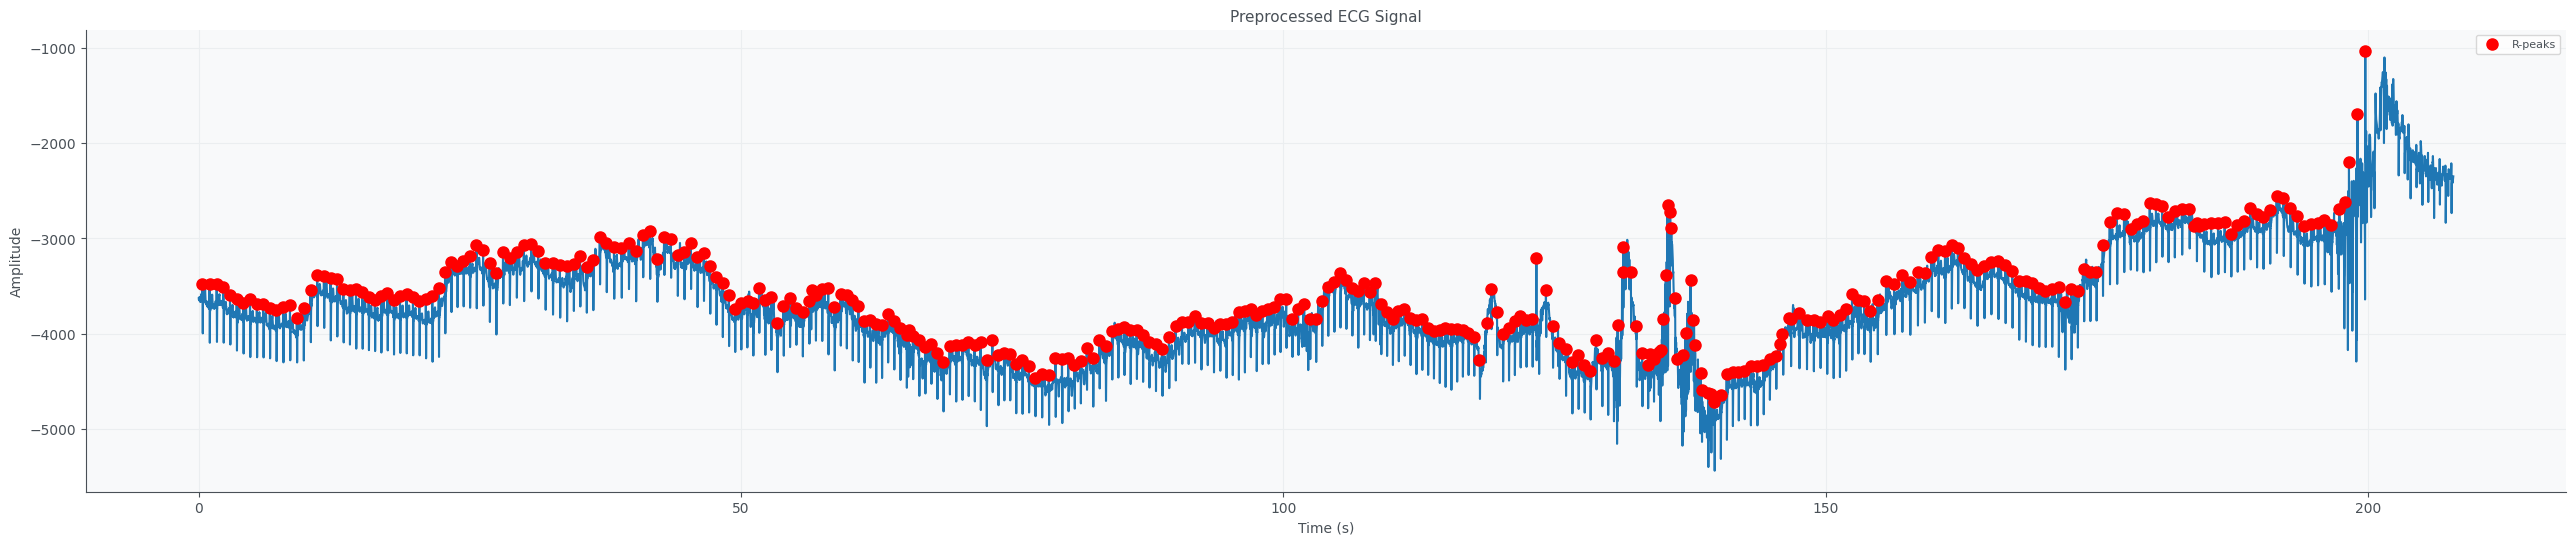

In [4]:

# Plot the preprocessed ECG signal
time = np.arange(len(filtered_signal)) / sampling_rate

plt.figure(figsize=(32, 6))
plt.plot(time, filtered_signal)
plt.plot(r_peaks / sampling_rate, filtered_signal[r_peaks], 'ro', markersize=8, label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Preprocessed ECG Signal')
plt.legend()
plt.grid(True)
plt.show()


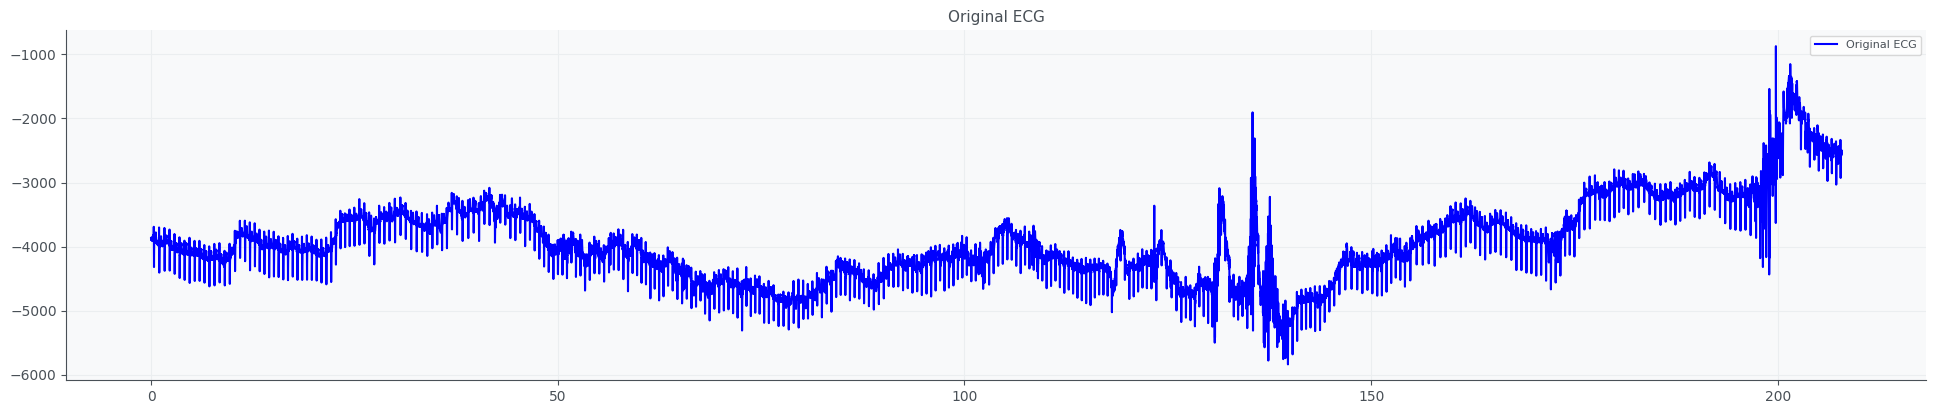

In [5]:
plt.figure(figsize=(24, 10))
plt.subplot(211)
plt.plot(time, ecg_signal, label='Original ECG', color='blue')
plt.title('Original ECG')
plt.legend()

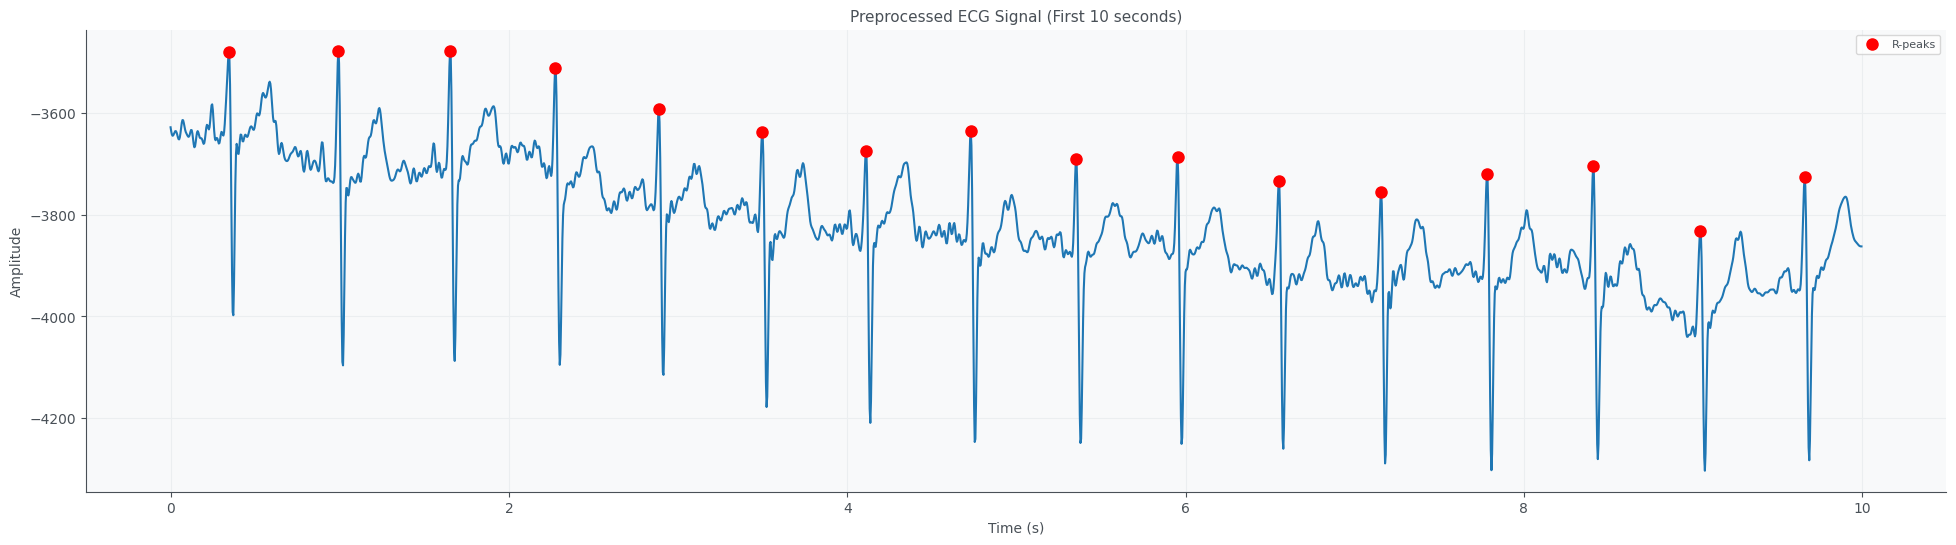

In [6]:

# Plot the first 10 seconds of the preprocessed ECG signal
plt.figure(figsize=(24, 6))
plt.plot(time[:10*sampling_rate], filtered_signal[:10*sampling_rate])
plt.plot(r_peaks[:np.sum(r_peaks <= 10*sampling_rate)] / sampling_rate,
         filtered_signal[r_peaks[:np.sum(r_peaks <= 10*sampling_rate)]], 'ro', markersize=8, label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Preprocessed ECG Signal (First 10 seconds)')
plt.legend()
plt.grid(True)
plt.show()

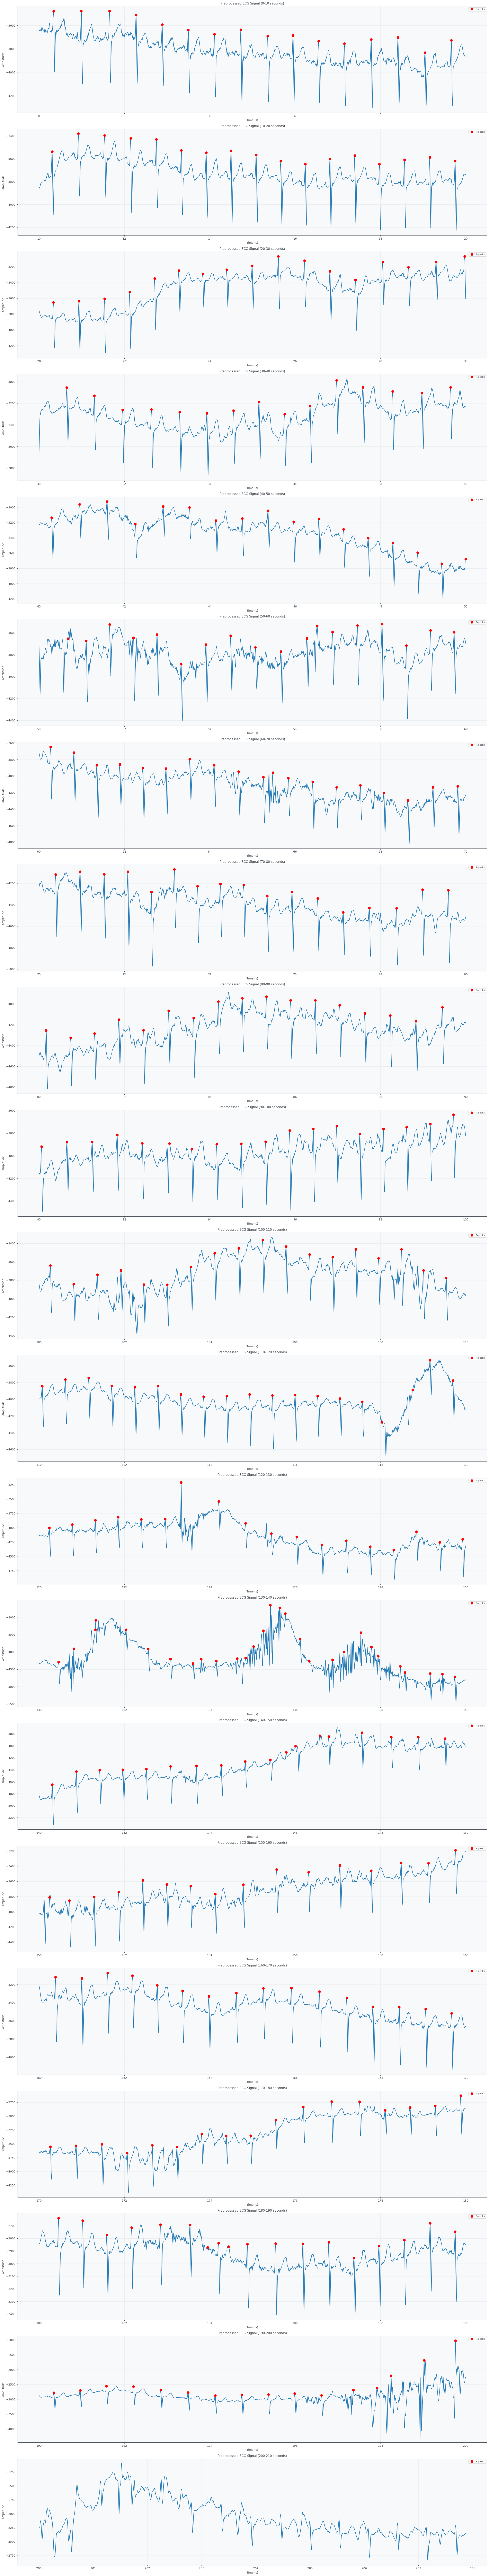

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already preprocessed the ECG signal and obtained the filtered_signal and r_peaks

# Calculate the total duration of the ECG signal
total_duration = len(filtered_signal) / sampling_rate

# Define the time intervals for plotting
time_intervals = [(i, i+10) for i in range(0, int(total_duration), 10)]

# Create a figure with subplots for each time interval
num_plots = len(time_intervals)
fig, axs = plt.subplots(num_plots, 1, figsize=(24, 6 * num_plots))

# Plot the preprocessed ECG signal and R-peaks for each time interval
for i, (start_time, end_time) in enumerate(time_intervals):
    start_sample = int(start_time * sampling_rate)
    end_sample = int(end_time * sampling_rate)
    
    axs[i].plot(time[start_sample:end_sample], filtered_signal[start_sample:end_sample])
    
    r_peaks_interval = r_peaks[(r_peaks >= start_sample) & (r_peaks < end_sample)]
    axs[i].plot(r_peaks_interval / sampling_rate, filtered_signal[r_peaks_interval], 'ro', markersize=8, label='R-peaks')
    
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title(f'Preprocessed ECG Signal ({start_time}-{end_time} seconds)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [8]:
'''
import numpy as np
from scipy.signal import welch

def calculate_hf_hrv(rr_intervals, sampling_rate):
    # Convert RR intervals to evenly sampled time series
    rr_times = np.cumsum(rr_intervals)
    rr_times -= rr_times[0]
    
    # Interpolate the RR intervals to obtain an evenly sampled signal
    interpolation_frequency = 4.0  # Adjust the interpolation frequency as needed
    rr_interp = np.interp(np.arange(0, rr_times[-1], 1/interpolation_frequency), rr_times, rr_intervals)
    
    # Perform frequency-domain analysis using Welch's method
    freq, psd = welch(rr_interp, fs=interpolation_frequency, nperseg=len(rr_interp))
    
    # Define the HF band (0.15-0.4 Hz)
    hf_band = np.logical_and(freq >= 0.15, freq <= 0.4)
    
    # Calculate HF power
    hf_power = np.trapz(psd[hf_band], freq[hf_band])
    
    return hf_power

rr_intervals = np.diff(r_peaks) / sampling_rate

average_heart_rate = 60 / np.mean(rr_intervals)
print("Average Heart Rate: {:.2f} bpm".format(average_heart_rate))

# Calculate HF-HRV
hf_hrv = calculate_hf_hrv(rr_intervals, sampling_rate)
print("HF-HRV:", hf_hrv)
'''

'\nimport numpy as np\nfrom scipy.signal import welch\n\ndef calculate_hf_hrv(rr_intervals, sampling_rate):\n    # Convert RR intervals to evenly sampled time series\n    rr_times = np.cumsum(rr_intervals)\n    rr_times -= rr_times[0]\n    \n    # Interpolate the RR intervals to obtain an evenly sampled signal\n    interpolation_frequency = 4.0  # Adjust the interpolation frequency as needed\n    rr_interp = np.interp(np.arange(0, rr_times[-1], 1/interpolation_frequency), rr_times, rr_intervals)\n    \n    # Perform frequency-domain analysis using Welch\'s method\n    freq, psd = welch(rr_interp, fs=interpolation_frequency, nperseg=len(rr_interp))\n    \n    # Define the HF band (0.15-0.4 Hz)\n    hf_band = np.logical_and(freq >= 0.15, freq <= 0.4)\n    \n    # Calculate HF power\n    hf_power = np.trapz(psd[hf_band], freq[hf_band])\n    \n    return hf_power\n\nrr_intervals = np.diff(r_peaks) / sampling_rate\n\naverage_heart_rate = 60 / np.mean(rr_intervals)\nprint("Average Heart Rate

In [9]:
import numpy as np
from scipy.signal import welch, resample
from biosppy.signals import ecg
import pywt


def calculate_hrv_indices(rr_intervals, sampling_rate):
    # Resample RR intervals to 4 Hz using cubic-spline interpolation
    resampled_rr = resample(rr_intervals, int(len(rr_intervals) * 4 / sampling_rate))
    
    # Calculate TFR using CWT
    wavelet = 'morl'  # Choose the appropriate wavelet (e.g., Morlet)
    scales = np.arange(1, 101)  # Adjust the range of scales as needed
    coef, freqs = pywt.cwt(resampled_rr, scales, wavelet)
    
    # Calculate time-domain HRV indices
    sdrr = np.std(rr_intervals)
    #rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = (nn50 / len(rr_intervals)) * 100
    
    # Calculate frequency-domain HRV indices using Welch's method
    freq, psd = welch(resampled_rr, fs=4.0, nperseg=len(resampled_rr))
    lf_band = np.logical_and(freq >= 0.04, freq < 0.15)
    hf_band = np.logical_and(freq >= 0.15, freq <= 0.4)
    lf_power = np.trapz(psd[lf_band], freq[lf_band])
    hf_power = np.trapz(psd[hf_band], freq[hf_band])
    lf_hf_ratio = lf_power / hf_power
    if hf_power != 0:
        lf_hf_ratio = lf_power / hf_power
    else:
        lf_hf_ratio = 1
    
    return sdrr, rmssd, pnn50, lf_power, hf_power, lf_hf_ratio, coef, freqs


# Calculate RR intervals
rr_intervals = np.diff(r_peaks) / sampling_rate
average_heart_rate = 60 / np.mean(rr_intervals)

# Calculate HRV indices and TFR
sdrr, rmssd, pnn50, lf_power, hf_power, lf_hf_ratio, coef, freqs = calculate_hrv_indices(rr_intervals, sampling_rate)

# Print the HRV indices
print("Time-domain HRV indices:")
print("Average Heart Rate: {:.2f} bpm".format(average_heart_rate))
print("SDRR:", sdrr)
print("RMSSD:", rmssd)
print("PNN50:", pnn50)
print("Frequency-domain HRV indices:")
print("LF Power:", lf_power)
print("HF Power:", hf_power)
print("LF/HF Ratio:", lf_hf_ratio)

Time-domain HRV indices:
Average Heart Rate: 106.81 bpm
SDRR: 0.11129094758207271
RMSSD: 112.76716464784255
PNN50: 19.154929577464788
Frequency-domain HRV indices:
LF Power: 0.0
HF Power: 0.0
LF/HF Ratio: 1


C:\Users\lal\AppData\Local\Temp\ipykernel_21300\1955081313.py:28: RuntimeWarning: invalid value encountered in scalar divide
  lf_hf_ratio = lf_power / hf_power
